<a href="https://colab.research.google.com/github/iamhannahkoh/DeepLearning/blob/main/Stock_Market_Prediction_with_LSTM_Tiingo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock Market Prediction Using LSTM

**About the Data**

We will use Apple Inc. (AAPL) Stock Price data from Tiingo for stock market prediction. 

### 1. Set up data

In [ ]:
import pandas_datareader as pdr
import pandas as pd

In [ ]:
# You need to log into (or create one) your Tiingo account to get your activation key.
key="Insert your key here"
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('/tmp/AAPL.csv')

In [ ]:
df=pd.read_csv('/tmp/AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-01-12 00:00:00+00:00,99.96,100.69,98.8399,100.55,49154227,23.149595,23.318654,22.890192,23.286232,196616908,0.0,1.0
1,AAPL,2016-01-13 00:00:00+00:00,97.39,101.19,97.3000,100.32,62439631,22.554412,23.434449,22.533569,23.232967,249758524,0.0,1.0
2,AAPL,2016-01-14 00:00:00+00:00,99.52,100.48,95.7400,97.96,63170127,23.047696,23.270021,22.172291,22.686417,252680508,0.0,1.0
3,AAPL,2016-01-15 00:00:00+00:00,97.13,97.71,95.3600,96.20,79833891,22.494199,22.628520,22.084287,22.278822,319335564,0.0,1.0
4,AAPL,2016-01-19 00:00:00+00:00,96.66,98.65,95.5000,98.41,53087747,22.385352,22.846214,22.116710,22.790632,212350988,0.0,1.0


In [ ]:
df1=df.reset_index()['close']
df1

0        99.96
1        97.39
2        99.52
3        97.13
4        96.66
         ...  
1253    129.41
1254    131.01
1255    126.60
1256    130.92
1257    132.05
Name: close, Length: 1258, dtype: float64

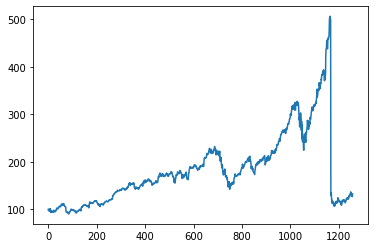

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

### 2. Preprocessing

In [ ]:
# LSTM models are sensitive to the scale of the data so we apply Min<ax scaler here.

import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.02313891]
 [0.01695731]
 [0.02208058]
 ...
 [0.08721587]
 [0.09760673]
 [0.10032471]]


In [ ]:
# Train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

training_size,test_size

(817, 441)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 3. Modeling

In [ ]:
import tensorflow as tf

In [ ]:
model=tf.keras.models.Sequential([tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(100,1)),
                                  tf.keras.layers.LSTM(50, return_sequences=True),
                                  tf.keras.layers.LSTM(50),
                                  tf.keras.layers.Dense(1)])

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 124ms/step - loss: 0.0159 - val_loss: 0.0612
Epoch 2/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0032 - val_loss: 0.0259
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0013 - val_loss: 0.0232
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 4.7434e-04 - val_loss: 0.0214
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 4.4891e-04 - val_loss: 0.0216
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 4.1437e-04 - val_loss: 0.0209
Epoch 7/100
12/12 [==============================] - 0s 21ms/step - loss: 3.8389e-04 - val_loss: 0.0199
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 4.2490e-04 - val_loss: 0.0194
Epoch 9/100
12/12 [==============================] - 0s 20ms/step - loss: 3.1783e-04 - val_loss: 0.0195
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss:

### 4. Prediction

In [ ]:
# Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

159.83940209067103

In [ ]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

269.6715711959941

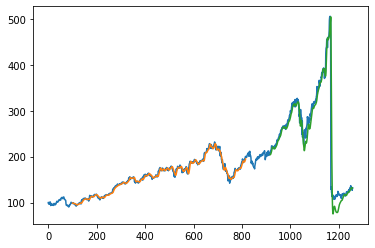

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

temp_input

[0.89455201443175,
 0.8959470835838845,
 0.9206494287432352,
 0.9792904389657247,
 0.9936019242333134,
 0.9836680697534577,
 1.0,
 0.9854479855682503,
 0.983499699338545,
 0.09308478653036678,
 0.10544798556825014,
 0.09876127480457003,
 0.07345760673481655,
 0.07365003006614551,
 0.05407095610342749,
 0.06489476849067943,
 0.055682501503307225,
 0.052098616957306054,
 0.0601683704149128,
 0.06061334936861096,
 0.05241130487071555,
 0.04810583283223091,
 0.03968731208659049,
 0.04748045700541187,
 0.05164161154539987,
 0.04036079374624174,
 0.04300661455201443,
 0.05277209861695731,
 0.05921828021647624,
 0.05712567648827421,
 0.06126277811184605,
 0.06361996392062536,
 0.05455201443174984,
 0.062922429344558,
 0.05488875526157544,
 0.059506915213469624,
 0.059242333132892344,
 0.06405291641611544,
 0.08192423331328924,
 0.07398677089597111,
 0.07420324714371618,
 0.07304870715574258,
 0.06898376428141911,
 0.061671677690920024,
 0.06535177390258567,
 0.06381238725195432,
 0.0611184606

In [ ]:
# Prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.09488589]
101
1 day input [0.89594708 0.92064943 0.97929044 0.99360192 0.98366807 1.
 0.98544799 0.9834997  0.09308479 0.10544799 0.09876127 0.07345761
 0.07365003 0.05407096 0.06489477 0.0556825  0.05209862 0.06016837
 0.06061335 0.0524113  0.04810583 0.03968731 0.04748046 0.05164161
 0.04036079 0.04300661 0.0527721  0.05921828 0.05712568 0.06126278
 0.06361996 0.05455201 0.06292243 0.05488876 0.05950692 0.05924233
 0.06405292 0.08192423 0.07398677 0.07420325 0.07304871 0.06898376
 0.06167168 0.06535177 0.06381239 0.06111846 0.0594107  0.05943476
 0.06316296 0.05017438 0.06008419 0.044546   0.04432952 0.04834636
 0.05919423 0.06900782 0.06819002 0.06248948 0.06164762 0.07011425
 0.06944077 0.06956103 0.07206254 0.06987372 0.06660253 0.06806975
 0.06494287 0.05654841 0.05972339 0.06179194 0.06313891 0.06905592
 0.07788334 0.07874925 0.07841251 0.07675286 0.08036079 0.08187613
 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465 0.09012628
 0.09226699 0.08734817 0.0911365  0.09991

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

1258

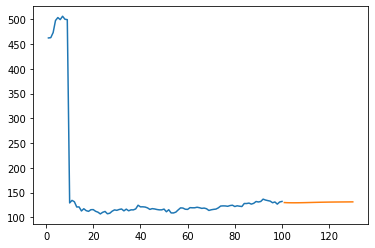

In [ ]:
# Visualization
import matplotlib.pyplot as plt

plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

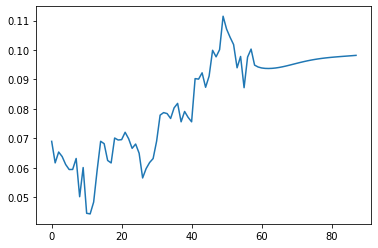

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

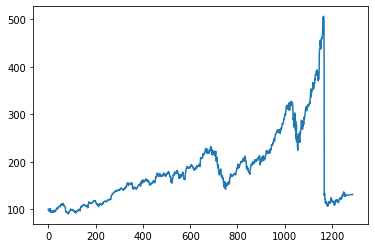

In [ ]:
plt.plot(df3)